Car object Localization using Convolutional Neural Networks

---



## Importing Libraries

In [1]:
#importing libs
import pandas as pd
import os
import PIL
import numpy as np
from PIL import Image,ImageOps
from os import listdir
from os.path import isfile, join
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
!git clone https://github.com/AdityaDeodeshmukh/Real-time-object-detection



fatal: destination path 'Real-time-object-detection' already exists and is not an empty directory.


## Loading the dataset
First we extract the images and the annotation data from the folder and csv. For this we loop through the images in the training images folder and if we find the annotation data for that particular image in the csv file we add it to the dataset for bounding box regression


In [3]:
mypath="Real-time-object-detection/data/training_images"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

In [4]:
dataset1=pd.read_csv("Real-time-object-detection/data/train_solution_bounding_boxes (1).csv")

In [5]:
dataset1

,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422
...,...,...,...,...,...
554,vid_4_9860.jpg,0.000000,198.321729,49.235251,236.223284
555,vid_4_9880.jpg,329.876184,156.482351,536.664239,250.497895
556,vid_4_9900.jpg,0.000000,168.295823,141.797524,239.176652
557,vid_4_9960.jpg,487.428988,172.233646,616.917699,228.839864


In [6]:
present=list(dataset1["image"])

In [7]:
imag=Image.open("Real-time-object-detection/data/training_images/vid_4_1000.jpg")
width,height =imag.size

In [8]:
train_images = []
train_locs = []
train_labels = []

for im in onlyfiles:
    
    train_image_fullpath = os.path.join("Real-time-object-detection/data/training_images", im)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    if im in present:
        im_name,xmin,ymin,xmax,ymax=dataset1[dataset1["image"]==im].iloc[0]
        xmin = round(xmin/ width, 2)
        ymin = round(ymin/ height, 2)
        xmax = round(xmax/ width, 2)
        ymax = round(ymax/ height, 2)
        train_images.append(train_img_arr)
        train_locs.append((xmin,ymin,xmax,ymax))
        train_labels.append(1)
train_images = np.array(train_images)
train_locs = np.array(train_locs)
train_labels = np.array(train_labels)
        

Now we separate the training images to training and validation images. For this we use train_test_split from sklearn.

In [9]:
train_images_1 , val_images , train_locs, val_locs = train_test_split(train_images,train_locs,test_size=0.2, random_state=11)
train_images , val_images , train_labels, val_labels = train_test_split(train_images,train_labels,test_size=0.2, random_state=11)
train_images_1=[]

## Defining a ConvNET
Now we define a CNN model to extract features from the image. The model consisnts of a ConvNET which is connected to a **bounding box regression layer** and a **classification** layer.

First we Define the **input layer**

In [10]:
input_shape = (height, width, 3)
input_layer = tf.keras.layers.Input(input_shape ,name='base_pre')

Then we define the **base layer** of the ConvNET

In [11]:
base_layers = layers.experimental.preprocessing.Rescaling(1./255, name='base1')(input_layer)
base_layers = layers.Conv2D(16, 3, padding='same', activation='relu', name='base2')(base_layers)
base_layers = layers.MaxPooling2D(name='base3')(base_layers)
base_layers = layers.Conv2D(32, 3, padding='same', activation='relu', name='base4')(base_layers)
base_layers = layers.MaxPooling2D(name='base5')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='base6')(base_layers)
base_layers = layers.MaxPooling2D(name='base7')(base_layers)
base_layers = layers.Conv2D(64, 3, padding='same', activation='relu', name='base8')(base_layers)
base_layers = layers.MaxPooling2D(name='base9')(base_layers)
base_layers = layers.Flatten(name='base10')(base_layers)

Now we define the **classifier branch** that is attached to the base layers which will help in classifying if there is a car present in the image

In [12]:
classifier_branch = layers.Dense(128, activation='relu', name='classify1')(base_layers)
classifier_branch = layers.Dense(2, name='classifyHead')(classifier_branch)  

Now we define a **Bounding box regression** branch which will help in pinpointing the location of a car in the image.

In [13]:
BBox_Branch = layers.Dense(128, activation='relu', name='BBox1')(base_layers)
BBox_Branch = layers.Dense(64, activation='relu', name='BBox2')(BBox_Branch)
BBox_Branch = layers.Dense(32, activation='relu', name='BBox3')(BBox_Branch)
BBox_Branch = layers.Dense(4, activation='sigmoid', name='BBoxHead')(BBox_Branch)

## Bounding Box Regression


### Compiling model
Now we define the losses and compile the model

In [14]:
losses = {"classifyHead":tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), "BBoxHead":tf.keras.losses.MSE}

In [15]:
model = tf.keras.Model(input_layer,outputs=[classifier_branch,BBox_Branch])

In [16]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

In [17]:
trainTargets = {
    "classifyHead": train_labels,
    "BBoxHead": train_locs
}

valTargets = {
    "classifyHead": val_labels,
    "BBoxHead": val_locs
}


### Training the Model
Now we first train the bounding box regression layer of the CNN along with the base layers. <br>
For this we:


*   Train only on positive dataset (We do not consider images without cars)
*   Pass the train images and the train targets and fit the model to the dataset



In [18]:
history = model.fit(train_images, trainTargets,
                  validation_data=(val_images, valTargets),
             batch_size=4,
             epochs=5,
             shuffle=True,
             verbose=1)

Epoch 1/5
71/71 [==============================] - 10s 73ms/step - loss: 0.0599 - classifyHead_loss: 0.0099 - BBoxHead_loss: 0.0500 - classifyHead_accuracy: 0.9894 - BBoxHead_accuracy: 0.6690 - val_loss: 0.0409 - val_classifyHead_loss: 6.5279e-06 - val_BBoxHead_loss: 0.0409 - val_classifyHead_accuracy: 1.0000 - val_BBoxHead_accuracy: 0.6620
Epoch 2/5
71/71 [==============================] - 4s 63ms/step - loss: 0.0475 - classifyHead_loss: 1.0657e-05 - BBoxHead_loss: 0.0475 - classifyHead_accuracy: 1.0000 - BBoxHead_accuracy: 0.6937 - val_loss: 0.0427 - val_classifyHead_loss: 4.6525e-05 - val_BBoxHead_loss: 0.0426 - val_classifyHead_accuracy: 1.0000 - val_BBoxHead_accuracy: 0.6620
Epoch 3/5
71/71 [==============================] - 4s 63ms/step - loss: 0.0417 - classifyHead_loss: 4.0329e-06 - BBoxHead_loss: 0.0417 - classifyHead_accuracy: 1.0000 - BBoxHead_accuracy: 0.6972 - val_loss: 0.0227 - val_classifyHead_loss: 0.0000e+00 - val_BBoxHead_loss: 0.0227 - val_classifyHead_accuracy: 1.00

In [19]:
train_images = []
train_locs = []
train_labels = []

### Defining prediction function
Now we define a function that can take an image input to feed into the
ConvNET to extract the classifier output and the bounding box output

In [20]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt



In [21]:
def PredictImg(address):
  test_img = img = image.load_img(address, target_size=(height, width))
  img_array = image.img_to_array(test_img)
  img_array = np.expand_dims(img_array, axis=0)
  PRED=model.predict(img_array)
  cls=PRED[0]
  cls=np.argmax(cls)
  bbox=PRED[1]
  x1=bbox[0][0]*width
  y1=bbox[0][1]*height
  x2=bbox[0][2]*width
  y2=bbox[0][3]*height
  shape=[x1,y1,x2,y2]
  if(cls==1):
    img1 = ImageDraw.Draw(test_img)
    img1.rectangle(shape, outline ="green",width=4)
  plt.figure(figsize=(10,6))
  plt.imshow(test_img)
  plt.show()

### Testing on positive Image
Now we extract an image with a car and visualize it before feeding it into the prediction function

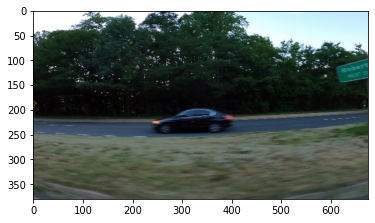

In [47]:
im="vid_5_26620.jpg"
address=os.path.join("Real-time-object-detection/data/testing_images", im)

img=Image.open(address)
plt.imshow(img)
plt.show()

Now we display the bounding box

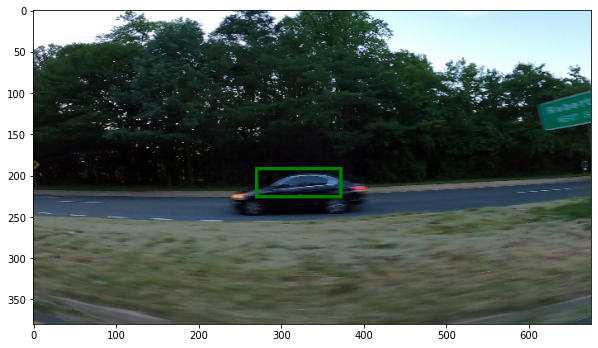

In [31]:
PredictImg(address)

### Testing on negative images
This model has a problem though. If you feed it a negative image, It will give you a random bounding box since we have only trained on positive images

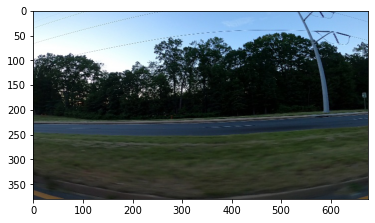

In [33]:
im="vid_5_25100.jpg"
address=os.path.join("Real-time-object-detection/data/testing_images", im)

img=Image.open(address)
plt.imshow(img)
plt.show()


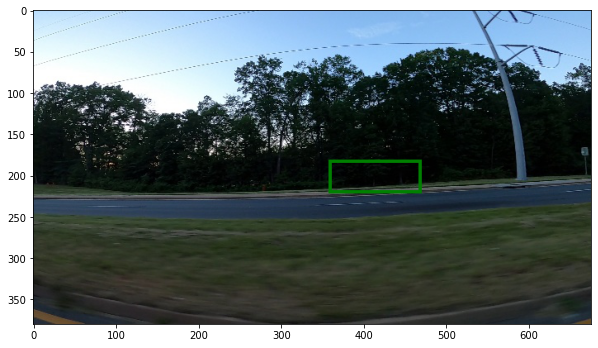

In [34]:
PredictImg(address)

As we can see above, there is no car and yet it is giving a bounding box.

## Classifier Branch:
To solve this problem we train the classifier branch. We do this by feeding the model positive as well as negative images and freezing the rest of the model.

This way only the classifier branch is trained and the bounding box regression branch is unaffected


### Initializing the model
First we make the base layers and the bounding box layers untrainable

In [35]:
for layer in model.layers:
    if layer.name.startswith('base'):
        layer.trainable = False
    if layer.name.startswith('BBox'):
        layer.trainable = False

In [36]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 base_pre (InputLayer)          [(None, 380, 676, 3  0           []                               
                                )]                                                                
                                                                                                  
 base1 (Rescaling)              (None, 380, 676, 3)  0           ['base_pre[0][0]']               
                                                                                                  
 base2 (Conv2D)                 (None, 380, 676, 16  448         ['base1[0][0]']                  
                                )                                                                 
                                                                                              

Now we compile the new model with the changes

In [37]:
model.compile(loss=losses, optimizer='Adam', metrics=['accuracy'])

### Loading the dataset
Now we load the dataset with positive and negative images

In [38]:
train_images = []
train_locs = []
train_labels = []

for im in onlyfiles:
    train_image_fullpath = os.path.join("Real-time-object-detection/data/training_images", im)
    train_img = keras.preprocessing.image.load_img(train_image_fullpath, target_size=(height, width))
    train_img_arr = keras.preprocessing.image.img_to_array(train_img)
    if im in present:
        im_name,xmin,ymin,xmax,ymax=dataset1[dataset1["image"]==im].iloc[0]
        xmin = round(xmin/ width, 2)
        ymin = round(ymin/ height, 2)
        xmax = round(xmax/ width, 2)
        ymax = round(ymax/ height, 2)
        train_images.append(train_img_arr)
        train_locs.append((xmin,ymin,xmax,ymax))
        train_labels.append(1)
    else:
        train_images.append(train_img_arr)
        train_locs.append((0,0,0,0))
        train_labels.append(0)
train_images = np.array(train_images)
train_locs = np.array(train_locs)
train_labels = np.array(train_labels)

In [39]:
train_images_1 , val_images , train_locs, val_locs = train_test_split(train_images,train_locs,test_size=0.2, random_state=11)
train_images , val_images , train_labels, val_labels = train_test_split(train_images,train_labels,test_size=0.2, random_state=11)

In [40]:
train_images_1=[]

### Training the model
Now we set the train targets for the various output heads\

In [41]:
trainTargets = {
    "classifyHead": train_labels,
    "BBoxHead": train_locs
}

valTargets = {
    "classifyHead": val_labels,
    "BBoxHead": val_locs
}

Next we fit the model to the dataset with both positive and negative heads. This will only change the classifier head since the other layers have been made untrainable

In [42]:
history = model.fit(train_images, trainTargets,
                  validation_data=(val_images, valTargets),
             batch_size=4,
             epochs=8,
             shuffle=True,
             verbose=1)

Epoch 1/8
200/200 [==============================] - 8s 35ms/step - loss: 0.8466 - classifyHead_loss: 0.6530 - BBoxHead_loss: 0.1935 - classifyHead_accuracy: 0.7900 - BBoxHead_accuracy: 0.3363 - val_loss: 0.4712 - val_classifyHead_loss: 0.2744 - val_BBoxHead_loss: 0.1968 - val_classifyHead_accuracy: 0.9055 - val_BBoxHead_accuracy: 0.3333
Epoch 2/8
200/200 [==============================] - 7s 34ms/step - loss: 0.3813 - classifyHead_loss: 0.1878 - BBoxHead_loss: 0.1935 - classifyHead_accuracy: 0.9287 - BBoxHead_accuracy: 0.3363 - val_loss: 0.4030 - val_classifyHead_loss: 0.2062 - val_BBoxHead_loss: 0.1968 - val_classifyHead_accuracy: 0.9303 - val_BBoxHead_accuracy: 0.3333
Epoch 3/8
200/200 [==============================] - 6s 31ms/step - loss: 0.3055 - classifyHead_loss: 0.1120 - BBoxHead_loss: 0.1935 - classifyHead_accuracy: 0.9700 - BBoxHead_accuracy: 0.3363 - val_loss: 0.3765 - val_classifyHead_loss: 0.1797 - val_BBoxHead_loss: 0.1968 - val_classifyHead_accuracy: 0.9154 - val_BBoxHe

### Test on Positive Image
Now we first test out the model on a positive image

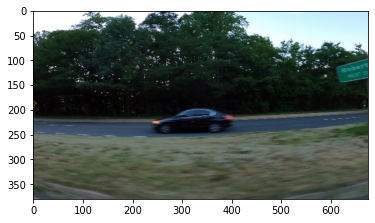

In [43]:
im="vid_5_26620.jpg"
address=os.path.join("Real-time-object-detection/data/testing_images", im)

img=Image.open(address)
plt.imshow(img)
plt.show()

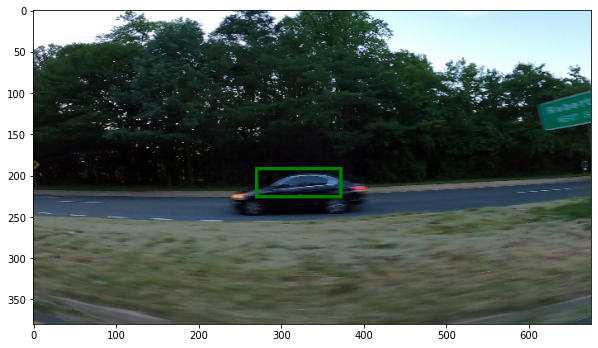

In [44]:
PredictImg(address)

As we can see the bounding box branch of the model is unaffected as the bounding box we have recieved has not changed

### Test on Negative Image
Now we test out the model on a negative image

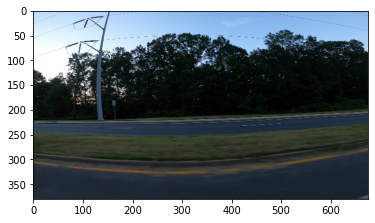

In [45]:
im="vid_5_25200.jpg"
address=os.path.join("Real-time-object-detection/data/testing_images", im)

img=Image.open(address)
plt.imshow(img)
plt.show()

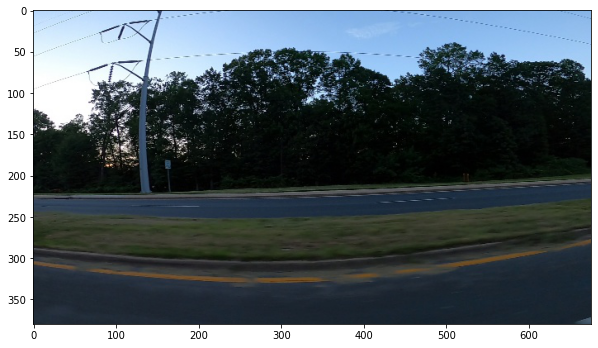

In [46]:
PredictImg(address)

As we can see the model did not detect the presence of a car and so, it did not draw a bounding box